# Tubastraea spp larvae drift

Here we try to model the larvae dispersion using a known source colony location and with the current velocities the model displays the path and destination of these larvaes.

## 1. Importing packages

### Configuration libs
Firtly we need to import all the necessary libs to run our model. The command below helps to prevent graphic errors using the matplot lib to show graphs and plots on jupyter notebooks.

In [1]:
%matplotlib notebook
#calling it a second time may prevent some graphics errors
%matplotlib notebook
%load_ext autoreload
%autoreload 2

The code below changes the display to use 100% of the monitor resulting in a better experience on wide monitors.

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

### Main libs

Here we are importing some standard libs for our code and the Opendrift readers packages to read our shapefiles and NetCDFs. The tubastraea packages defines our larvae model extending the OpenDrift package.

In [3]:
from datetime import timedelta
from datetime import datetime

In [4]:
from opendrift.readers import reader_netCDF_CF_generic
from opendrift.readers import reader_global_landmask
from opendrift.readers import reader_shape

In [34]:
from tubastraea import Tubastraea

## 2. Defining domains area and necessary files

Now it is necessary to define which files (shapefiles and NetCDFs) we are going to use in our model.

### Domain extent of the landmask

The landmask is necessary for the larvae to interact with the coast and we need to define the domain area (lat,long) we are going to work with. Bear in mind that if you use broader areas you are going to need more RAM memory on your computer. OpenDrift uses GSHHG (https://www.soest.hawaii.edu/pwessel/gshhg/) as a default landmask. GSHHG is a high resolution geographic data set.

In [6]:
lat_min = -29
lat_max = -26

long_min = -49
long_max = -48

domain = [long_min, lat_min, long_max, lat_max]
reader_landmask = reader_global_landmask.Reader(extent=domain)

### Ocean currents

To model the larvae path we need the ocean current velocities. For tubastraea model we are going to use a global reanalysis data supplied by Copernicus Marine Service (https://resources.marine.copernicus.eu). 

This data was downloaded and regrided following the instructions here. 

After that just choose between years and rescaling of the regrided NetCDF.

In [7]:
reader_currents = reader_netCDF_CF_generic.Reader([
    '/data/global-reanalysis-phy-001-030-daily/02_3km_regrid_joined/grid_1998.nc'
])

### Rocky reef for larvae settlement

Another necessary file is a shapefile defining the reefs or places where a larvae is most likely to settle.

In [8]:
reader_reef = reader_shape.Reader.from_shpfiles('/data/shapefiles/costoes/pol_diferenca_costao_terra_p14.shp')

### Known larvae sources

Here we define variables containing known locations of Tubastraea colonies to be used later as larvae seeds.

In [9]:
# GPS Rancho Norte
seed_rn = [-48.381440, -27.277070]

# 2012 - Engenho (EG)
seed_eg = [-48.367384, -27.291957]

# 2014 - Saco do Vidal (SV);-27.297.548;-48.360.013
seed_sv = [-48.360013, -27.297548]
# 2013 - Farol (SF)
seed_sf = [-48.363786, -27.296645]

# 2015 - Galé (GI)
seed_gi = [-48.40758, -27.17785]

# 2008 - Plataforma Petrobrás
seed_plataforma = [-46.77, -26.767222]

## 3. Running the model


### Instantiate the class

First we create the Tubastraea object from our model and define the starting variables.

In [48]:
# Lof level limits the amount of output log displayed on screen. Use 50 to disable log.
log_level = 50

# Instantiate the larvae Class
o = Tubastraea(loglevel=log_level)

# We are going to work only with the horizontal motion
o.disable_vertical_motion()

# Adding our readed files
o.add_reader([reader_currents, reader_reef, reader_landmask])

# Defining the priority landmask
o.priority_list['land_binary_mask'] = ['global_landmask']

# Defining the reef shapefiles
o.reef_shapes = ['shape']

# The factor is a velocity multiplier against the current values. A 0.5 factor will dislocate the larvae at 50% of the current velocity.
o.factor = 0.5

### Time period

Here we define how long our model will run. The NetCDF must have the current velocities for these dates.

In [49]:
start = datetime(1998, 3, 5, 0, 0, 0)
end = datetime(1998, 3, 15, 0, 0, 0)

### Seeding larvaes to known locations

There are a few ways to seed the elements and you can find more in the OpenDrift documentation (https://opendrift.github.io/tutorial.html#seeding-elements).

We are seeding the larvaes on a costant basis. Bellow we tell the model to seed the number of larvaes distributed equally between the start and end defined previously.

In [50]:
o.seed_elements(lon=seed_rn[0], lat=seed_rn[1], number=10, radius=50, time=[start, end])

### Running the model

Finally we run the model with a timestep of one hour. We find one hour a good number because if you choose longer timesteps (eg. 4 hours or 6 hours) the larvae can be outside the reef in one timestep and cross the entire reef in the next step failing to settle. And if you use smaller timesteps will only takes more time to run the model with approximately the same result.

In [51]:
o.run(end_time=end, time_step=timedelta(hours=1))

## To save the output to a file uncomment the following lines
# ncfile = '/data/coral_sol_output.nc'
# o.run(end_time=end, time_step=timedelta(hours=1), outfile=ncfile)

## 4. Plotting and saving last coordinates

OpenDrift has a default function and Tubastraea has a custom plot to include the reef shapefile.

### Default plotting function

We can use a different domain than the starting one in case the particles are outside the domain.

<IPython.core.display.Javascript object>


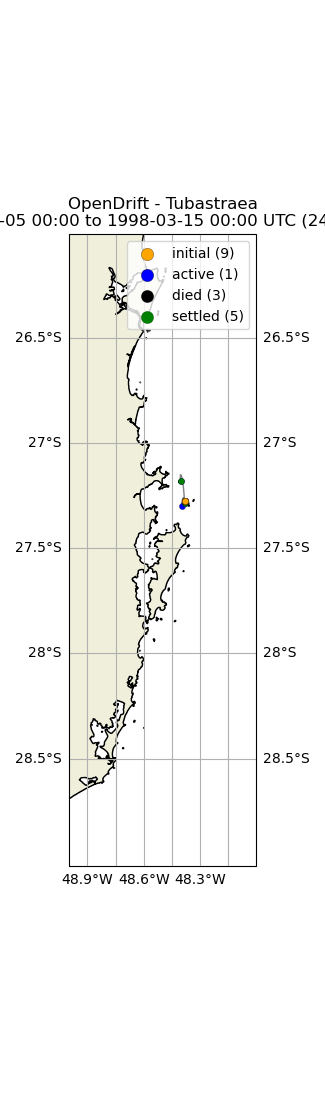

(<GeoAxesSubplot:title={'center':'OpenDrift - Tubastraea\n1998-03-05 00:00 to 1998-03-15 00:00 UTC (241 steps)'}>,
 <module 'matplotlib.pyplot' from '/opt/conda/envs/opendrift/lib/python3.9/site-packages/matplotlib/pyplot.py'>)

In [52]:
# If you want to use a different domain uncomment the next line
#domain = [-49, -31, -44, -24]

# Corners are rearrenged in a different order for plotting
corners = [long_min, long_max, lat_min, lat_max]
o.plot(corners=corners)

### Custom plotting function

<IPython.core.display.Javascript object>


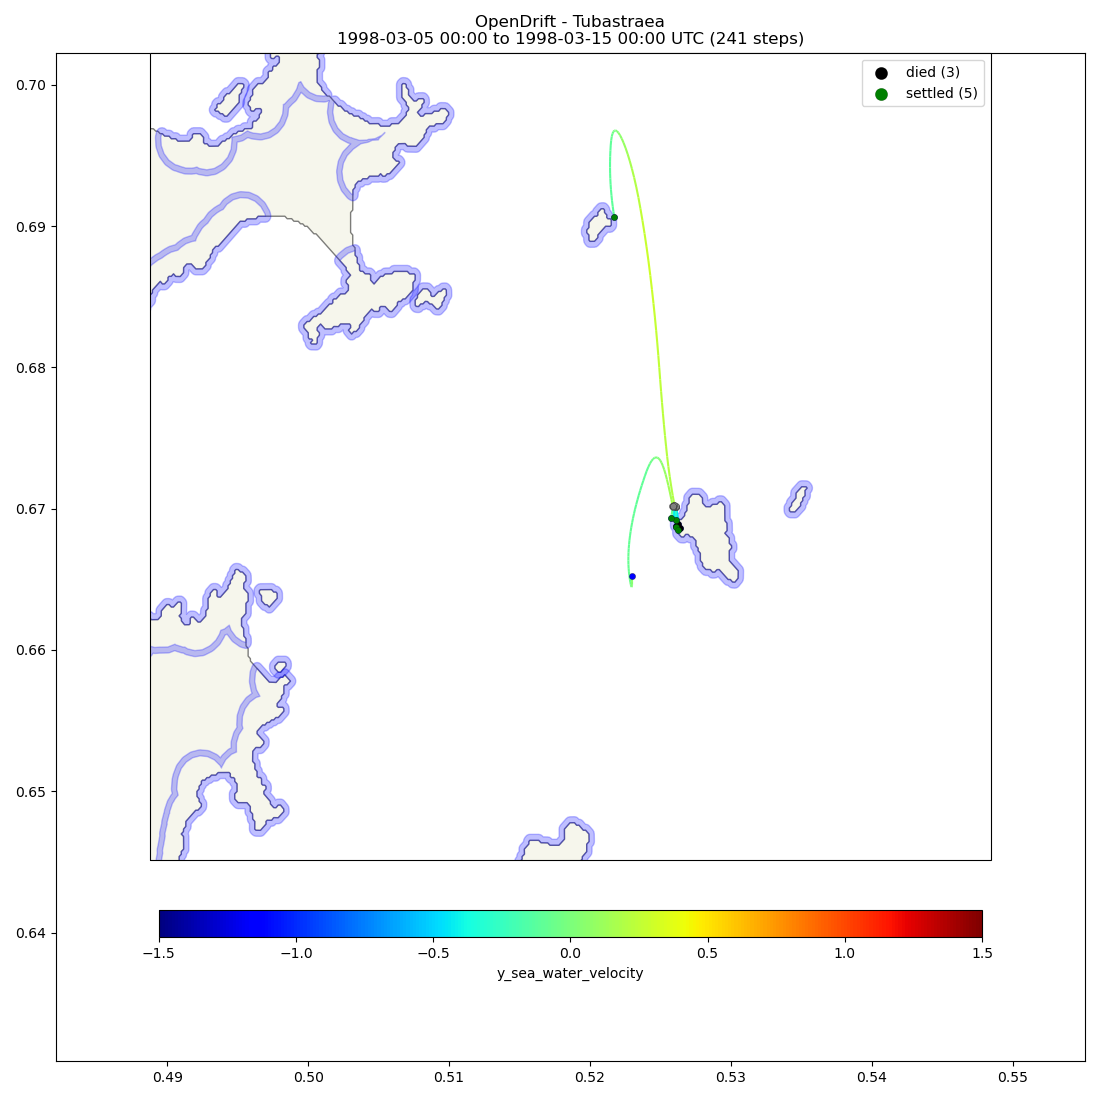

In [53]:
o.plot_reef(corners=corners, linecolor='y_sea_water_velocity', lvmin=-1.5, lvmax=1.5)

In [22]:
lons, lats = o.get_lonlats()

In [24]:
lons.T

masked_array(
  data=[[-48.381351470947266, -48.38142013549805, --, ..., --, --, --],
        [-48.380577087402344, -48.380645751953125, -48.38138961791992,
         ..., --, --, --],
        [--, --, -48.38051986694336, ..., --, --, --],
        ...,
        [--, --, --, ..., -48.381465911865234, --, --],
        [--, --, --, ..., -48.381473541259766, -48.381465911865234,
         -48.38140869140625],
        [--, --, --, ..., -48.381500244140625, -48.381492614746094,
         -48.38143539428711]],
  mask=[[False, False,  True, ...,  True,  True,  True],
        [False, False, False, ...,  True,  True,  True],
        [ True,  True, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False,  True,  True],
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ..., False, False, False]],
  fill_value=1e+20,
  dtype=float32)

In [25]:
lons

masked_array(
  data=[[-48.381351470947266, -48.380577087402344, --, ..., --, --, --],
        [-48.38142013549805, -48.380645751953125, --, ..., --, --, --],
        [--, -48.38138961791992, -48.38051986694336, ..., --, --, --],
        ...,
        [--, --, --, ..., -48.381465911865234, -48.381473541259766,
         -48.381500244140625],
        [--, --, --, ..., --, -48.381465911865234, -48.381492614746094],
        [--, --, --, ..., --, -48.38140869140625, -48.38143539428711]],
  mask=[[False, False,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ...,  True, False, False]],
  fill_value=1e+20,
  dtype=float32)

In [54]:
o.history['lon']

masked_array(
  data=[[-48.380550384521484, -48.37972640991211, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --],
        [--, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, -48.3812370300293,
         -48.380252838134766, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --, --, --, --, --,
         --, --, --, --, --, --, --, --, --, --, --, --

In [56]:
o.history['lat'][1]

masked_array(data=[--, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --,
                   -27.276412963867188, -27.283676147460938, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, --, --, --, --, --, --, --, --, --, --,
                   --, --, --, --, 

In [30]:
o.history['status']

masked_array(
  data=[[0, 1, --, ..., --, --, --],
        [0, 1, --, ..., --, --, --],
        [--, 0, 1, ..., --, --, --],
        ...,
        [--, --, --, ..., 0, 0, 0],
        [--, --, --, ..., --, 0, 0],
        [--, --, --, ..., --, 0, 0]],
  mask=[[False, False,  True, ...,  True,  True,  True],
        [False, False,  True, ...,  True,  True,  True],
        [ True, False, False, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ..., False, False, False],
        [ True,  True,  True, ...,  True, False, False],
        [ True,  True,  True, ...,  True, False, False]],
  fill_value=999999,
  dtype=int32)

In [61]:
activation, deactivation = o.index_of_activation_and_deactivation()

rows = []

for idx, val in enumerate(deactivation):
    start_idx = activation[idx]
    stop_idx = val
    larvae_stop = {
        'larvae_idx': idx,
        'lat_start': o.history['lat'][idx][start_idx],
        'lon_start': o.history['lon'][idx][start_idx],
        'lat_stop': o.history['lat'][idx][stop_idx],
        'lon_stop': o.history['lon'][idx][stop_idx],
        'timesteps': val - activation[idx]
    }
    rows.append(larvae_stop)

In [62]:
rows

[{'larvae_idx': 0, 'lat': -27.282705, 'lon': -48.379726, 'timesteps': 1},
 {'larvae_idx': 1, 'lat': -27.283676, 'lon': -48.380253, 'timesteps': 1},
 {'larvae_idx': 2, 'lat': -27.28465, 'lon': -48.3798, 'timesteps': 1},
 {'larvae_idx': 3, 'lat': -27.284182, 'lon': -48.379032, 'timesteps': 1},
 {'larvae_idx': 4, 'lat': -27.281507, 'lon': -48.38038, 'timesteps': 1},
 {'larvae_idx': 5, 'lat': -27.283464, 'lon': -48.380238, 'timesteps': 1},
 {'larvae_idx': 6, 'lat': -27.180727, 'lon': -48.403458, 'timesteps': 57},
 {'larvae_idx': 7, 'lat': -27.29995, 'lon': -48.396862, 'timesteps': 54},
 {'larvae_idx': 8, 'lat': -27.280935, 'lon': -48.38215, 'timesteps': 3}]

In [63]:
import csv
fieldnames = ['larvae_idx', 'lat_start', 'lon_start', 'lon_start', 'lon_stop', 'timesteps']
with open('larvae_stops.csv', 'w', encoding='UTF8', newline='') as f:    
    writer = csv.DictWriter(f, fieldnames=fieldnames)
    writer.writeheader()
    writer.writerows(rows)